## Jessica Williams- Relax Takehome Challenge

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from yellowbrick.text import FreqDistVisualizer
from pathlib import Path
nlp=spacy.load('en_core_web_sm')
from textblob import TextBlob, Word, Blobber
from sklearn.ensemble import RandomForestRegressor

#from sb_utils import save_file

In [2]:
user_info = pd.read_csv('takehome_users.csv',encoding="ISO-8859-1")
#user_info = pd.read_csv('C:/Users/jwatki8/Documents/Data Science Program information/relax_challenge/takehome_users.csv')

In [3]:
user_eng = pd.read_csv('C:/Users/jwatki8/Documents/Data Science Program information/relax_challenge/takehome_user_engagement.csv')

In [4]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
user_info.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [7]:
user_info=user_info.rename(columns={'object_id': 'user_id'})

In [8]:
user_eng['user_id'].nunique()

8823

In [9]:
user_eng.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [10]:
user_eng['visit_count']=user_eng['user_id'].groupby(user_eng['user_id']).transform('count')

In [11]:
user_eng['time_stamp']= pd.to_datetime(user_eng['time_stamp'])

In [12]:
#adopted user creation section based on having 3 in 7

My first step is to to find the 'adopted users' in the dataset.

In [13]:
user_eng['time_stamp']= pd.to_datetime(user_eng['time_stamp'])

In [14]:
user_eng['date'] = pd.to_datetime(user_eng.time_stamp.dt.date)

In [15]:
def rolling_count(user_eng_group, frequency):
    return user_eng_group.rolling(frequency, on='date')['user_id'].count()

In [16]:
user_eng['visits_7_days'] = user_eng.groupby('user_id', as_index=False, group_keys=False).apply(rolling_count, '7D')

In [17]:
user_eng.head()

,time_stamp,user_id,visited,visit_count,date,visits_7_days
0,2014-04-22 03:53:30,1,1,1,2014-04-22,1.0
1,2013-11-15 03:45:04,2,1,14,2013-11-15,1.0
2,2013-11-29 03:45:04,2,1,14,2013-11-29,1.0
3,2013-12-09 03:45:04,2,1,14,2013-12-09,1.0
4,2013-12-25 03:45:04,2,1,14,2013-12-25,1.0


In [18]:
user_eng[user_eng.visits_7_days >= 3.0]

,time_stamp,user_id,visited,visit_count,date,visits_7_days
9,2014-02-09 03:45:04,2,1,14,2014-02-09,3.0
10,2014-02-13 03:45:04,2,1,14,2014-02-13,3.0
27,2013-02-19 22:08:03,10,1,284,2013-02-19,3.0
30,2013-03-02 22:08:03,10,1,284,2013-03-02,3.0
31,2013-03-05 22:08:03,10,1,284,2013-03-05,3.0
...,...,...,...,...,...,...
207898,2014-05-23 11:04:47,11988,1,30,2014-05-23,6.0
207899,2014-05-24 11:04:47,11988,1,30,2014-05-24,6.0
207900,2014-05-26 11:04:47,11988,1,30,2014-05-26,5.0
207901,2014-05-27 11:04:47,11988,1,30,2014-05-27,5.0


In [19]:
adopted = user_eng.groupby('user_id')['visits_7_days'].max().reset_index()

In [20]:
adopted['adopted_user'] = adopted['visits_7_days'].apply(lambda x: 1 if x>=3 else 0)

In [21]:
adopted.set_index('user_id', inplace = True)

In [22]:
adopted.head()

,visits_7_days,adopted_user
user_id,,
1,1.0,0
2,3.0,1
3,1.0,0
4,1.0,0
5,1.0,0


Next I would like to merge the newly created adopted user information with the user information dataframe

In [23]:
#merging the user information with new dataframe

In [24]:
users = user_info.join(adopted, on = 'user_id', how='left')

In [25]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  visits_7_days               8823 non-null   float64
 11  adopted_user                8823 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 1.1+ MB


In [26]:
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visits_7_days,adopted_user
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,3.0,1.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0,0.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,0.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,0.0


Now let's examine what we have.

In [27]:
users['adopted_user'].value_counts()

0.0    7221
1.0    1602
Name: adopted_user, dtype: int64

The perentage of adopted users in this data set is around 18 percent so that is something to keep in mind while examining relationships with other features.

In [28]:
users['creation_source'].value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

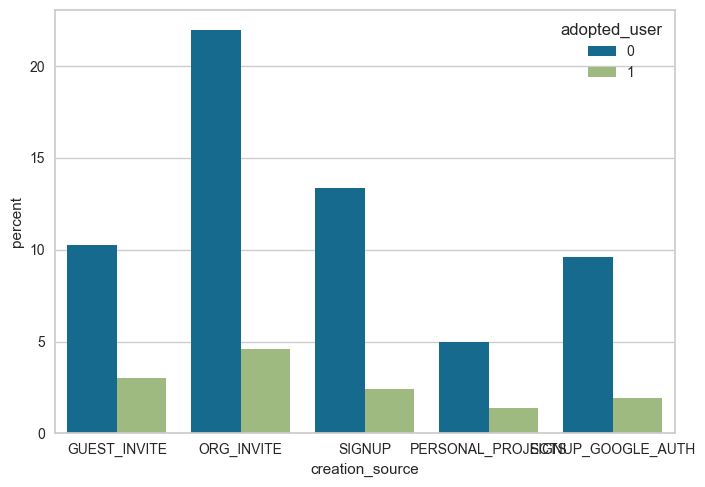

In [29]:
sns.countplot(data=users, x='creation_source', hue='adopted_user',hue_order=(0,1),stat='percent')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

The creation source variable doesn’t seem to have a large effect on predicting adopted users.

Let's take a look at the distribution of adopted users over some of the other variables.

In [30]:
users['opted_in_to_mailing_list'].value_counts()

0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

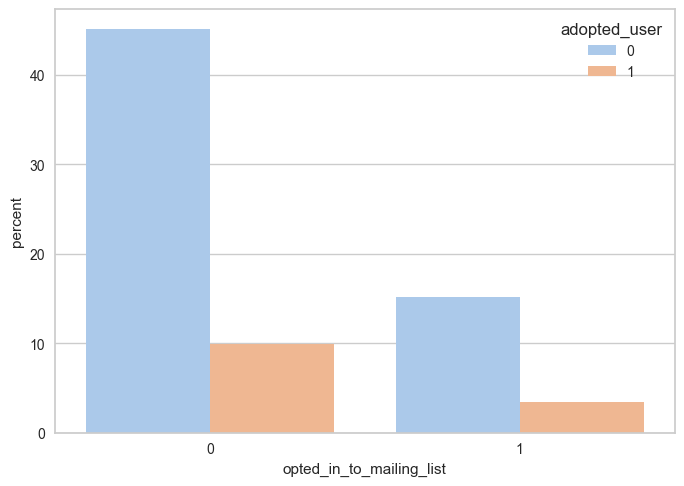

In [31]:
sns.countplot(data=users, x='opted_in_to_mailing_list', hue='adopted_user',hue_order=(0,1),palette='pastel', stat='percent')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [32]:
users['enabled_for_marketing_drip'].value_counts()

0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64

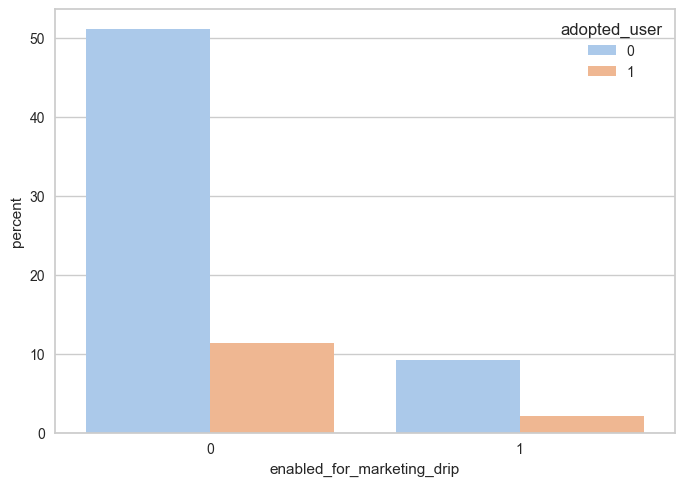

In [33]:
sns.countplot(data=users, x='enabled_for_marketing_drip', hue='adopted_user',hue_order=(0,1),palette='pastel', stat='percent')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

It looks like the distributions of the adopted users are the same through these specific variables as they are over the entire dataset.

In [34]:
#creating dummies for creation source variable
users = pd.get_dummies(users, columns=['creation_source'])

In [35]:
users_short=users.drop(columns=['user_id','name', 'email'])

In [36]:
users_c=users_short.apply(lambda x: x.factorize()[0]).corr()

In [37]:
users_c.corr()['adopted_user']

creation_time                         0.035806
last_session_creation_time            0.681293
opted_in_to_mailing_list             -0.093444
enabled_for_marketing_drip           -0.042429
org_id                               -0.092943
invited_by_user_id                    0.047360
visits_7_days                         0.940513
adopted_user                          1.000000
creation_source_GUEST_INVITE         -0.282412
creation_source_ORG_INVITE           -0.066936
creation_source_PERSONAL_PROJECTS    -0.566807
creation_source_SIGNUP                0.214929
creation_source_SIGNUP_GOOGLE_AUTH    0.268309
Name: adopted_user, dtype: float64

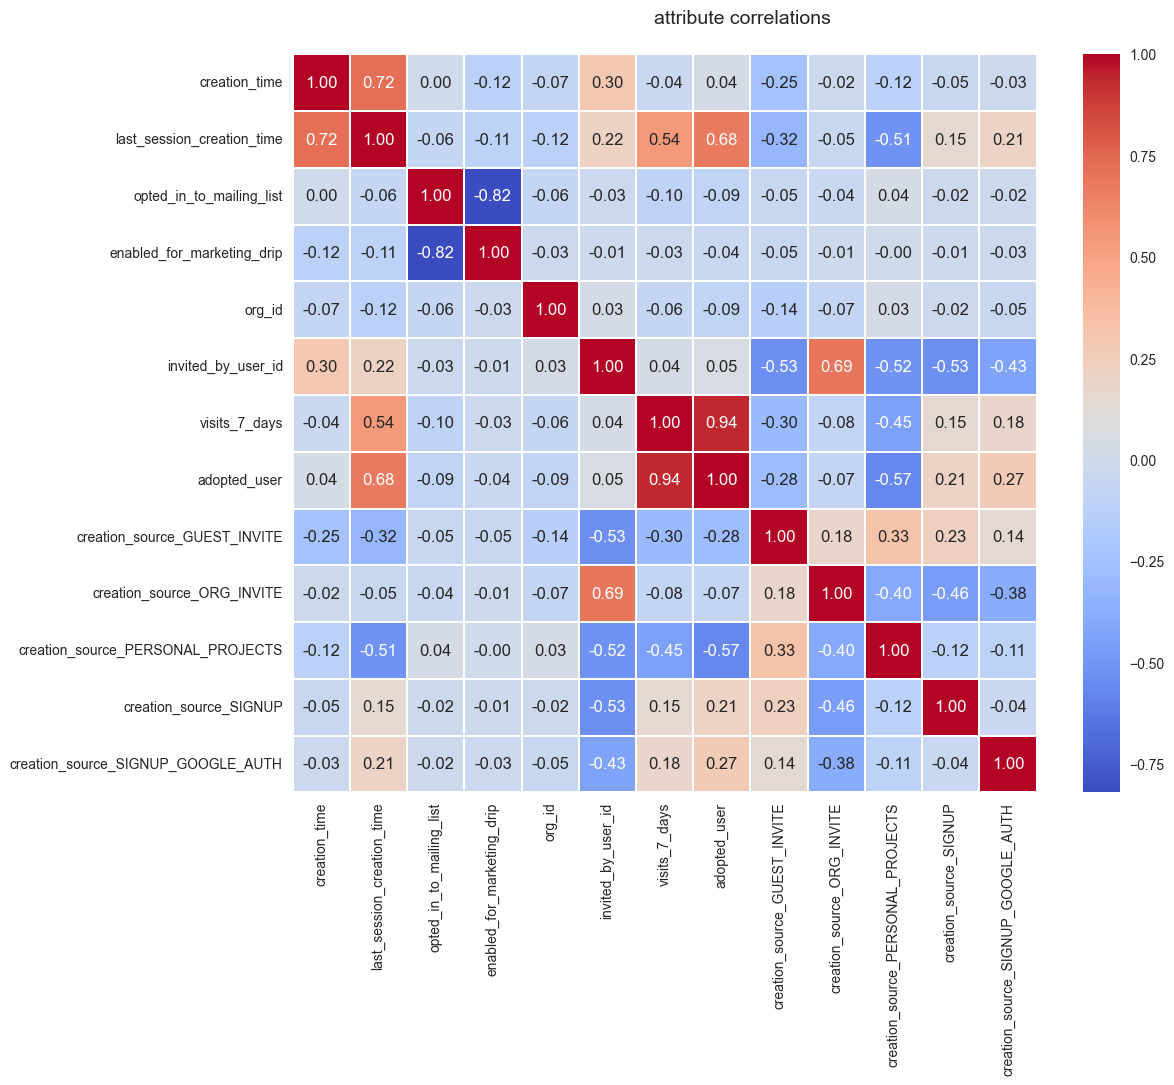

In [38]:
corrmat = users_c.corr()
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('attribute correlations', fontsize=14)

After examining the correlation I can see a few moderate correlations. The creation source of personal projects seems to have a negative correlation to adopted users. There is also a moderate negative correlation with guest source creation invite.

## Conclusion

Overall I don't see any factors that seem to predict future user adoption. The correlations between the adopted user variable and the other facors are weak. Also the representation of adopted users in the distribution of the individual factors are not much different than the adopted user distribution in the full dataset.